# Classification with Dynamic Time Warping

## Setup

In [12]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import dtw
from statistics import mode
import utils
import time

RESULTS_DIR = "results"
DATA_PICKLE_FILE = "generated_data/data_ntrain5_1658228687.pkl"
SPLIT_ID = 0

## Load data

In [13]:
with open(DATA_PICKLE_FILE, "rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['data_filename', 'time_index', 'models_lst', 'labels_df', 'all_X_samples', 'all_Z_samples', 'indices_splits_lst', 'metadata'])

In [14]:
print(data["metadata"])

{'N_TRAIN_SAMPLES_PER_MODEL': 5, 'N_TEST_SAMPLES_PER_MODEL': 30, 'MAX_SAMPLE_LEN': 50, 'MIN_SAMPLE_LEN': 20}


In [15]:
indices_splits_lst = data["indices_splits_lst"]
all_X_samples = data["all_X_samples"]
labels_df = data["labels_df"]
current_split = indices_splits_lst[SPLIT_ID]
train_samples_ids = current_split["train_samples_ids"]
test_samples_ids = current_split["test_samples_ids"]

In [16]:
len(current_split["test_samples_ids"])

270

## Classify test samples with DTW
For each test sample find DTW distance to all samples in train subset and classify as the closest one's label.

In [17]:
# TODO try cross-validation to choose better k
def classify_sample(X: np.ndarray, train_samples: list[np.ndarray], train_labels: list[int], k: int = 1) -> int:
    """Classify a sample using DTW with k-NN based on samples in `train_samples`."""
    if k >= len(train_samples):
        raise ValueError("k >= number of train examples doesn't make sense in KNN-classifier.")
    distances = []
    for Y in train_samples:
        normalized_dist = dtw.dtw(X, Y, distance_only= True).normalizedDistance
        distances.append(normalized_dist)
    first_k = np.argsort(distances)[:k] # TODO optimize
    return(mode(train_labels[first_k]))

In [18]:
train_df = labels_df.loc[train_samples_ids]
train_ids = train_df.index.values.astype('int')
train_samples = [all_X_samples[id] for id in train_ids]
train_labels = train_df["true_label"].values

test_df = labels_df.loc[test_samples_ids]
test_ids = test_df.index.values.astype('int')
test_samples = [all_X_samples[id] for id in test_ids]

In [19]:
start = time.time()
predictions_1NN = [classify_sample(X, train_samples, train_labels, 1) for X in test_samples]
predictions_5NN = [classify_sample(X, train_samples, train_labels, 5) for X in test_samples]
predictions_df = pd.DataFrame({
    "pred_label_1NN": predictions_1NN,
    "pred_label_5NN": predictions_5NN
}, index= test_df.index)
stop = time.time()
total_time = stop - start
print(f"Time needed to classify all test samples: {total_time:.2f}s")

classification_results = test_df.join(predictions_df)
classification_results.head()

Time needed to classify all test samples: 1.93s


,sample_id,true_label,sample_len,predicted_label_1NN,predicted_label_5NN
0,0,0,32,0,0
1,1,0,20,0,0
2,2,0,20,0,0
3,3,0,23,0,0
4,4,0,26,0,0


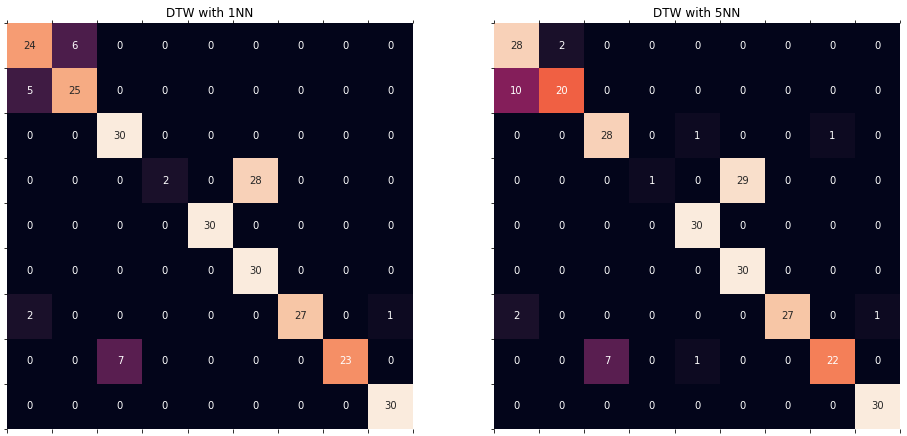

In [20]:
y_true = classification_results["true_label"]
y_pred_1NN = classification_results["pred_label_1NN"]
y_pred_5NN = classification_results["pred_label_5NN"]

cm_1NN = confusion_matrix(y_true, y_pred_1NN)
cm_5NN = confusion_matrix(y_true, y_pred_5NN)

plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(ncols = 2)
sns.heatmap(cm_1NN, annot=True, fmt='g', ax=axes[0], cbar = False)
axes[0].matshow(cm_1NN)
axes[0].set_title("DTW with 1NN")
sns.heatmap(cm_5NN, annot=True, fmt='g', ax=axes[1], cbar = False)
axes[1].matshow(cm_5NN)
axes[1].set_title("DTW with 5NN")
plt.show()

In [21]:
accuracies = dict()
true = classification_results["true_label"]
for col in utils.find_colnames_with(classification_results):
    acc = utils.accuracy(true, classification_results[col])
    accuracies[col] = acc
    print(f"{col} accuracy: {acc:.4f}")

predicted_label_1NN accuracy: 0.8185
predicted_label_5NN accuracy: 0.8000


In [22]:
time_index = data["time_index"]
summary = {
    "data_filename": DATA_PICKLE_FILE,
    "time_index": time_index,
    "split_id": SPLIT_ID,
    "results_df": classification_results,
    "accuracies": accuracies,
    "total_time": total_time
}

split_id_str = str(SPLIT_ID)
if len(split_id_str) == 1:
    split_id_str = "0" + split_id_str

output_path = f"{RESULTS_DIR}/dtw_results_{time_index}_{split_id_str}.pkl"
with open(output_path, 'wb') as f:
    pickle.dump(summary, f)
    print(f"Classification results saved to {output_path}.")

Classification results saved to results/dtw_results_1658228687_00.pkl.
